Random vectors on A100 GPU  --- for 400K computation takes 7min less time 18m vs 25m than CPU only for progressive.  The results are identical.

In [ ]:
!pip install ipython-autotime
%load_ext autotime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.0 MB/s eta 0:00:00
time: 217 µs (started: 2025-02-05 17:45:43 +00:00)


In [ ]:
import gzip
import gensim
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

time: 1.14 s (started: 2025-02-05 17:45:55 +00:00)


In [ ]:
import numpy as np
import random

from scipy import spatial

time: 467 µs (started: 2025-02-05 17:45:57 +00:00)


The code below will probably work faster with a local version

In [ ]:
#2M random vectors Pos
#Let's look at examples; note how we are preventing the normalized vectors from being zero
np.random.seed(27)
#Dim=150
Dim=200

Numvecs=400000
x = (2*np.random.rand(Dim)-1)
x = (x +0.001)/(np.linalg.norm(x) +0.001)
rand300d=[]
for i in range(Numvecs):
    y = (2*np.random.rand(Dim)-1)
    rand300d.append(y)

time: 3.28 s (started: 2025-02-05 17:46:00 +00:00)


In [ ]:
from sklearn.preprocessing import normalize



time: 491 ms (started: 2025-02-05 17:46:03 +00:00)


In [ ]:
# Call the function to get normalized word embeddings
normalized_embeddings = normalize(rand300d)


time: 939 ms (started: 2025-02-05 17:46:05 +00:00)


In [ ]:
len(normalized_embeddings)

400000

time: 2.21 ms (started: 2025-02-05 17:46:07 +00:00)


In [ ]:
!pip install faiss-gpu-cu12[fix-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cuda-runtime-cu12
    Found existing installation: nvidia-cuda-runtime-cu12 12.5.82
    Uninstalling nvidia-cuda-runtime-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-runtime-cu12-12.5.82
  Attempting uninstall: nvidia-cublas-cu12
    Found existing installation: nvidia-cublas-cu12 12.5.3.2
    Uninstalling nvidia-cublas-cu12-12.5.3.2:
      Successfully uninstalled nvidia-cublas-cu12-12.5.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-c

In [ ]:
import faiss
import matplotlib.pyplot as plt

time: 83 ms (started: 2025-02-05 17:46:39 +00:00)


In [ ]:
#Using spheres
#This code can be run.

def correlation_dimension_faiss(data, max_radius, num_radii=20,k=100):
    """
    Calculate the correlation dimension of the dataset using Faiss.

    :param data: numpy array of shape (n_samples, n_features)
    :param max_radius: maximum radius for correlation sum calculation
    :param num_radii: number of radii to use for calculation
    :return: radii, correlation_sum
    """
    n_samples, n_features = data.shape

    # Convert data to float32 (required by Faiss)
    data = data.astype(np.float32)

    # Create Faiss index
    index = faiss.IndexFlatL2(n_features)
    index.add(data)

    # Generate radii
    radii = np.logspace(-1, np.log10(max_radius), num_radii)

    # Calculate correlation sum for each radius
    correlation_sum = np.zeros(num_radii)
    for i, r in enumerate(radii):
        # Count number of neighbors within radius r for each point
        #print(index.range_search(data, r**2))
        #neighbors = index.range_search(data, r**2)  # Faiss uses squared distances
        #correlation_sum[i] = len(neighbors) / (n_samples * (n_samples - 1))

        distances, _ = index.search(data, k)

        # Count number of neighbors within radius r for each point
        count_within_radius = np.sum(distances < r**2, axis=1) - 1  # subtract 1 to exclude the point itself
        total_count = np.sum(count_within_radius)
        correlation_sum[i] = max(total_count / (n_samples * (n_samples - 1)), 1e-10)

    return radii, correlation_sum

def estimate_fractal_dimension(radii, correlation_sum):
    """
    Estimate fractal dimension from the slope of log-log plot.

    :param radii: array of radii used
    :param correlation_sum: array of correlation sums
    :return: estimated fractal dimension
    """
    log_radii = np.log(radii)
    log_correlation_sum = np.log(correlation_sum)

    print(log_radii,log_correlation_sum)
    # Linear regression to find slope
    coeffs = np.polyfit(log_radii, log_correlation_sum, deg=1)
    return coeffs[0]

time: 932 µs (started: 2025-02-05 17:46:39 +00:00)


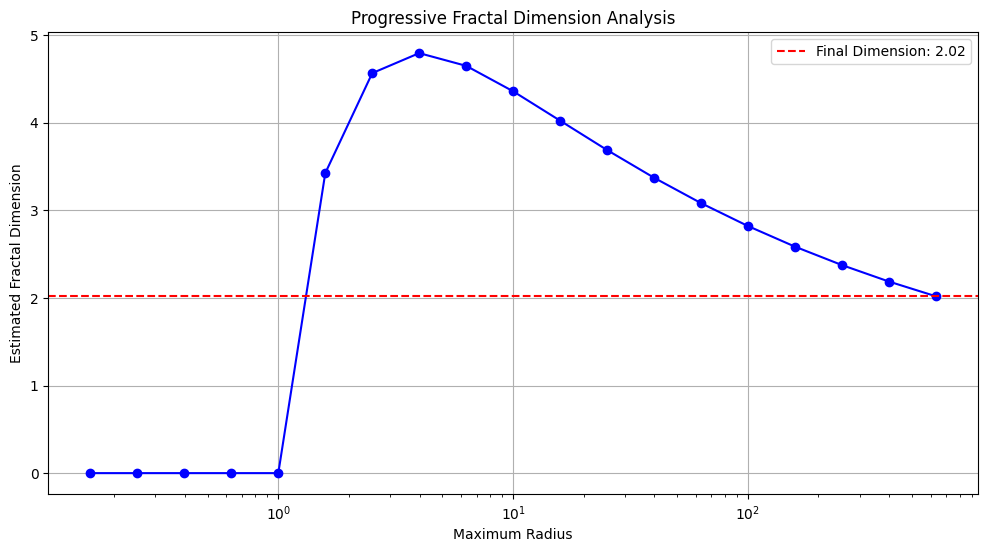

Final estimated fractal dimension: 2.02
Up to radius 0.1585: Estimated dimension = -0.00
Up to radius 0.2513: Estimated dimension = 0.00
Up to radius 0.3983: Estimated dimension = 0.00
Up to radius 0.6313: Estimated dimension = 0.00
Up to radius 1.0006: Estimated dimension = -0.00
Up to radius 1.5861: Estimated dimension = 3.42
Up to radius 2.5141: Estimated dimension = 4.57
Up to radius 3.9850: Estimated dimension = 4.79
Up to radius 6.3167: Estimated dimension = 4.65
Up to radius 10.0125: Estimated dimension = 4.36
Up to radius 15.8707: Estimated dimension = 4.02
Up to radius 25.1565: Estimated dimension = 3.69
Up to radius 39.8754: Estimated dimension = 3.37
Up to radius 63.2061: Estimated dimension = 3.08
Up to radius 100.1874: Estimated dimension = 2.82
Up to radius 158.8062: Estimated dimension = 2.58
Up to radius 251.7222: Estimated dimension = 2.37
Up to radius 399.0027: Estimated dimension = 2.19
Up to radius 632.4555: Estimated dimension = 2.02
time: 18min 11s (started: 2025-

In [ ]:
#Track progressive fractal dimension value, that is if I stop at 10^0 what is the fractal dimension before that?

def correlation_dimension_faiss(data, max_radius, num_radii=20, k=100):
    n_samples, n_features = data.shape
    data = data.astype(np.float32)

    index = faiss.IndexFlatL2(n_features)
    index.add(data)

    radii = np.logspace(-1, np.log10(max_radius), num_radii)
    correlation_sum = np.zeros(num_radii)

    distances, _ = index.search(data, k)

    for i, r in enumerate(radii):
        count_within_radius = np.sum(distances < r**2, axis=1) - 1
        total_count = np.sum(count_within_radius)
        correlation_sum[i] = max(total_count / (n_samples * (n_samples - 1)), 1e-10)

    return radii, correlation_sum

def estimate_fractal_dimension(radii, correlation_sum):
    valid_indices = correlation_sum > 0
    log_radii = np.log(radii[valid_indices])
    log_correlation_sum = np.log(correlation_sum[valid_indices])

    if len(log_radii) < 2:
        return np.nan

    coeffs = np.polyfit(log_radii, log_correlation_sum, deg=1)
    return coeffs[0]

def progressive_fractal_dimension(data, max_radius, num_radii=20, k=100):
    radii, correlation_sum = correlation_dimension_faiss(data, max_radius, num_radii, k)
    progressive_dimensions = []

    for i in range(2, len(radii) + 1):
        dim = estimate_fractal_dimension(radii[:i], correlation_sum[:i])
        progressive_dimensions.append(dim)

    return radii[1:], progressive_dimensions

# Example usage
if __name__ == "__main__":



    n_samples = len(normalized_embeddings)#, len(list(normalized_embeddings.values())[0]) WZ NO NAMES HERE
    embeddings_list = normalized_embeddings

    embeddings_list = embeddings_list[0:] #embeddings_list[0:100000]

    word_embeddings_fractal = np.array(embeddings_list, dtype=np.float32)

    max_radius = np.sqrt(len(embeddings_list))
    radii, progressive_dims = progressive_fractal_dimension(word_embeddings_fractal, max_radius)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(radii, progressive_dims, 'bo-')
    plt.xscale('log')
    plt.xlabel('Maximum Radius')
    plt.ylabel('Estimated Fractal Dimension')
    plt.title('Progressive Fractal Dimension Analysis')
    plt.grid(True)

    # Add final estimated dimension to the plot
    final_dim = progressive_dims[-1]
    plt.axhline(y=final_dim, color='r', linestyle='--', label=f'Final Dimension: {final_dim:.2f}')
    plt.legend()

    plt.show()

    print(f"Final estimated fractal dimension: {final_dim:.2f}")

    # Print progressive dimensions
    for i, (r, dim) in enumerate(zip(radii, progressive_dims)):
        print(f"Up to radius {r:.4f}: Estimated dimension = {dim:.2f}")

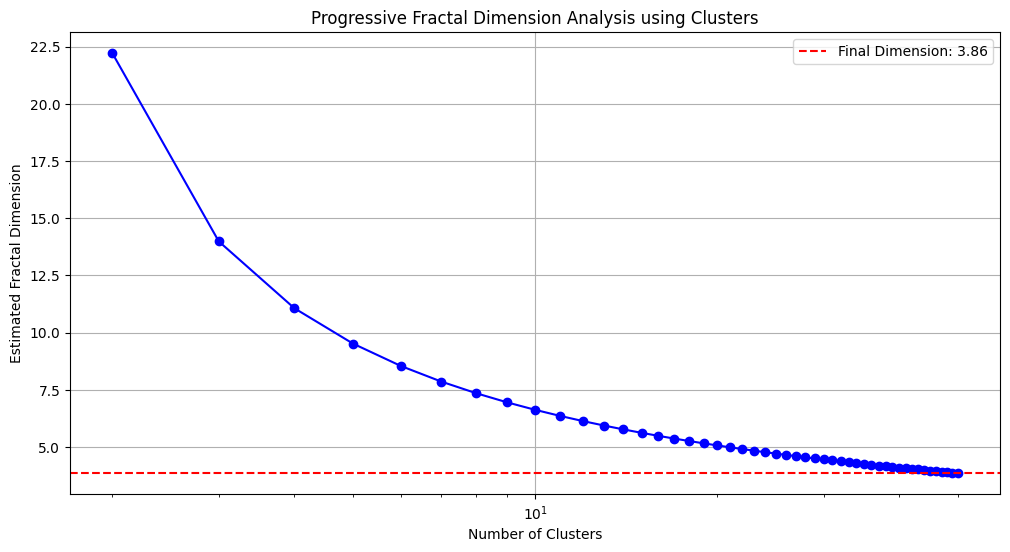


Number of clusters: 2
Cluster sizes: [213169 186831]
Cluster fractal dimensions: [17.70163812 17.51137433]
Total fractal dimension: 22.2194

Number of clusters: 3
Cluster sizes: [122802 142380 134818]
Cluster fractal dimensions: [10.66648235 10.80113061 10.75145538]
Total fractal dimension: 13.9881

Number of clusters: 4
Cluster sizes: [100853  92153 100133 106861]
Cluster fractal dimensions: [8.31094724 8.24587176 8.30577899 8.35268795]
Total fractal dimension: 11.0675

Number of clusters: 5
Cluster sizes: [84539 74062 81139 83759 76501]
Cluster fractal dimensions: [7.0490251  6.96681604 7.02351978 7.04326574 6.98694805]
Total fractal dimension: 9.5209

Number of clusters: 6
Cluster sizes: [68478 63879 70544 63024 73845 60230]
Cluster fractal dimensions: [6.21415318 6.17535229 6.23074252 6.16783172 6.25626585 6.14252417]
Total fractal dimension: 8.5430

Number of clusters: 7
Cluster sizes: [51597 58092 53259 58683 62889 59062 56418]
Cluster fractal dimensions: [5.57642336 5.63735342 

In [ ]:
#import faiss
#import matplotlib.pyplot as plt

def cluster_fractal_analysis(data, max_clusters, min_clusters=2):
    #1st row - cluster_sizes
    #2nd row - fractal dimension of each box/cluster
    #3rd row - average.
    n_samples, n_features = data.shape
    data = data.astype(np.float32)

    results = []

    for k in range(min_clusters, max_clusters + 1):
        kmeans = faiss.Kmeans(d=n_features, k=k, niter=300, verbose=False)
        kmeans.train(data)
        _, labels = kmeans.index.search(data, 1)

        # Calculate cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        cluster_sizes = counts[counts > 0]

        # Calculate fractal dimension for each cluster
        cluster_fractal_dims = np.log(cluster_sizes) / np.log(k)

        # Calculate total fractal dimension
        log_n = np.log(k)
        log_m = np.log(np.sum(cluster_sizes * np.log(cluster_sizes)))
        total_dimension = log_m / log_n if log_n != 0 else np.nan

        # Store results
        results.append({
            'num_clusters': k,
            'cluster_sizes': cluster_sizes,
            'cluster_fractal_dims': cluster_fractal_dims,
            'total_fractal_dim': total_dimension
        })

    return results

def cluster_fractal_dimension(data, max_clusters, min_clusters=2):
    n_samples, n_features = data.shape
    data = data.astype(np.float32)

    dimensions = []
    cluster_counts = range(min_clusters, max_clusters + 1)

    for k in cluster_counts:
        kmeans = faiss.Kmeans(d=n_features, k=k, niter=300, verbose=False)
        kmeans.train(data)
        _, labels = kmeans.index.search(data, 1)

        # Calculate cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        cluster_sizes = counts[counts > 0]

        # Calculate fractal dimension using box-counting method
        log_n = np.log(k)
        log_m = np.log(np.sum(cluster_sizes * np.log(cluster_sizes)))
        dimension = log_m / log_n if log_n != 0 else np.nan

        dimensions.append(dimension)

    return cluster_counts, dimensions

def progressive_fractal_dimension(data, max_clusters, min_clusters=2):
    cluster_counts, dimensions = cluster_fractal_dimension(data, max_clusters, min_clusters)
    return cluster_counts, dimensions

# Example usage
if __name__ == "__main__":
    # Assuming random_normalized_embeddings is your dictionary of word embeddings
    n_samples = len(normalized_embeddings)
  #  n_features = len(list(normalized_embeddings.values())[0])
    embeddings_list = normalized_embeddings

    word_embeddings_fractal = np.array(embeddings_list, dtype=np.float32)

    word_embeddings_fractal = word_embeddings_fractal[0:]

    max_clusters = min(50, n_samples // 2)  # Adjust based on your data size
    cluster_counts, progressive_dims = progressive_fractal_dimension(word_embeddings_fractal, max_clusters)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_counts, progressive_dims, 'bo-')
    plt.xscale('log')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Estimated Fractal Dimension')
    plt.title('Progressive Fractal Dimension Analysis using Clusters')
    plt.grid(True)

    # Add final estimated dimension to the plot
    final_dim = progressive_dims[-1]
    plt.axhline(y=final_dim, color='r', linestyle='--', label=f'Final Dimension: {final_dim:.2f}')
    plt.legend()

    plt.show()


    results = cluster_fractal_analysis(word_embeddings_fractal, max_clusters)

    # Print results
    for result in results:
        print(f"\nNumber of clusters: {result['num_clusters']}")
        print("Cluster sizes:", result['cluster_sizes'])
        print("Cluster fractal dimensions:", result['cluster_fractal_dims'])
        print(f"Total fractal dimension: {result['total_fractal_dim']:.4f}")